# Example

In this example, we will download ERA5 data for 1 Jan 2023 at 0.25 degrees resolution and run Aurora on this data. The fine-tuned version of Aurora specifically only works with IFS HRES T0, so we used the non-fine-tuned version of Aurora in this example.

## Downloading the Data

To begin with, register an account with the [CDS](https://cds.climate.copernicus.eu/) and create `$HOME/.cdsapirc` with the following content:

You can find your UID and API key on your account page.

We now download the ERA5 data.

In [1]:
from pathlib import Path

import cdsapi

# Data will be downloaded here.
download_path = Path("~/downloads")

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2023-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2023-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")

Static variables downloaded!
Surface-level variables downloaded!
Atmospheric variables downloaded!


## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires.

In [15]:
from datetime import datetime

import numpy as np
import torch
import xarray as xr

from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

i = 1  # Select this time index in the downloaded data.

batch = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensure that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.level.values),
    ),
)

## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions.

In [16]:
import torch

from aurora import Aurora

model = Aurora(use_lora=False)  # Pretrained version does not use LoRA.
model.load_checkpoint("wbruinsma/aurora", "aurora-0.25-pretrained.ckpt")

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    pred = model(batch)

model = model.to("cpu")
pred = pred.to("cpu")

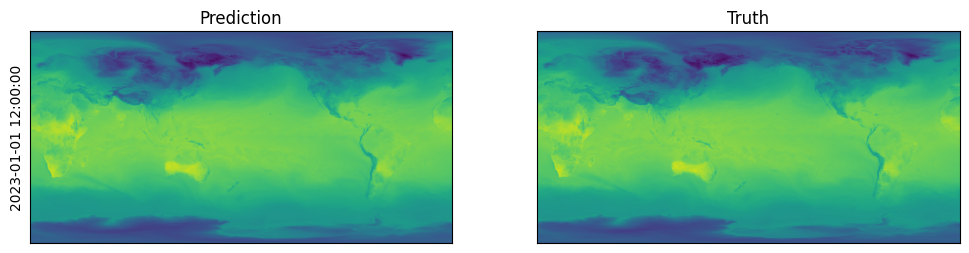

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 270, vmin=-50, vmax=50)
ax[0].set_ylabel(str(pred.metadata.time[0]))
ax[0].set_title("Prediction")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(surf_vars_ds["t2m"][2].values - 270, vmin=-50, vmax=50)
ax[1].set_title("Truth")
ax[1].set_xticks([])
ax[1].set_yticks([]);